In [1]:
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
xml_data = '/Users/ryand/Downloads/apple_health_export/export.xml'

In [37]:
class apple_health(object):
    def __init__(self, xml_data_path):
        self.tree = etree.parse(xml_data_path)
        self.root = self.tree.getroot()
        self.records = []
        for i, element in enumerate(self.root):
            self.records.append(element.attrib)
        self.r_types = []
        self.analyze_types()
        
    def analyze_types(self):
        for i, record in enumerate(self.records):
            try:
                if record['type'] not in self.r_types:
                    self.r_types.append(record['type'])
                else:
                    pass
            except:
                pass
        
    def extract_type(self, r_type):
        r_type_list = []
        for i, record in enumerate(self.records):
            try:
                if record['type'] == r_type:
                    r_type_list.append(record)
            except:
                pass
        r_type_list_ = [dict(record) for record in r_type_list]
        df = pd.DataFrame(r_type_list_, columns = r_type_list_[0].keys())
        time_col = ['startDate','endDate']
        for col in time_col:
            df[col] = pd.to_datetime(df[col])
        df['value'] = df['value'].astype(float)
        return df
    

In [38]:
my_data = apple_health(xml_data)
my_data.r_types

['HKQuantityTypeIdentifierHeight',
 'HKQuantityTypeIdentifierBodyMass',
 'HKQuantityTypeIdentifierHeartRate',
 'HKQuantityTypeIdentifierStepCount',
 'HKQuantityTypeIdentifierDistanceWalkingRunning',
 'HKQuantityTypeIdentifierBasalEnergyBurned',
 'HKQuantityTypeIdentifierActiveEnergyBurned',
 'HKQuantityTypeIdentifierFlightsClimbed',
 'HKQuantityTypeIdentifierNikeFuel',
 'HKQuantityTypeIdentifierAppleExerciseTime',
 'HKCategoryTypeIdentifierSleepAnalysis',
 'HKCategoryTypeIdentifierAppleStandHour',
 'HKCategoryTypeIdentifierMindfulSession']

In [79]:
df_ET = my_data.extract_type('HKQuantityTypeIdentifierAppleExerciseTime')
df_HR = df = my_data.extract_type('HKQuantityTypeIdentifierHeartRate')

In [80]:
def format_dates(df):
    df['date'] = df['startDate'].map(lambda x: x.date())
    sub_df = df.groupby('date').sum().reset_index()
    sub_df['month'] = sub_df['date'].map(lambda x: x.month)
    sub_df['year'] = sub_df['date'].map(lambda x: x.year)
    sub_df['day_of_month'] = sub_df['date'].map(lambda x: x.day)
    return sub_df

In [85]:
df_ET_ = format_dates(df_ET)

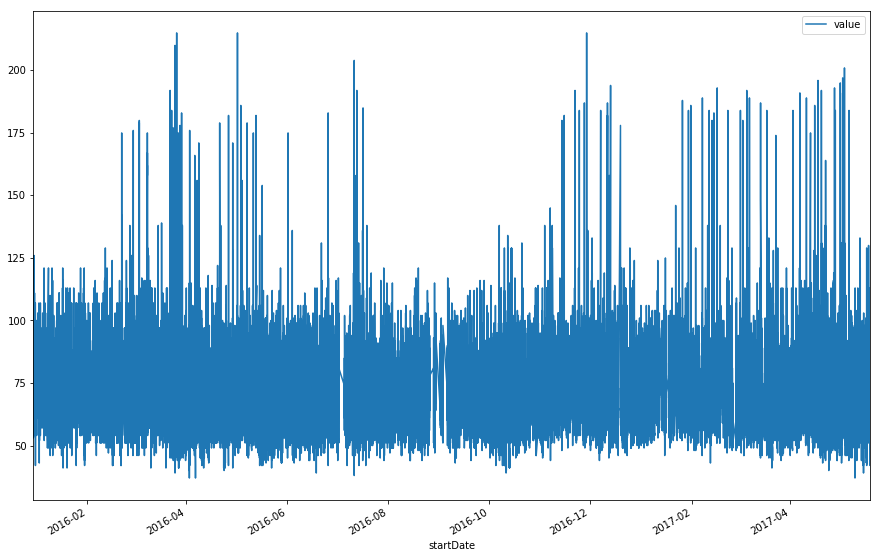

In [86]:
df_HR.groupby(['startDate']).median()[['value']].plot(figsize=(15,10))

In [70]:
df.groupby('month').median()

,value,year,day_of_month
month,,,
1,1.0,2017,18
2,1.0,2017,15
3,1.0,2017,17
4,1.0,2017,15
5,1.0,2016,12
6,1.0,2016,17
7,1.0,2016,17
8,1.0,2016,15
9,1.0,2016,19


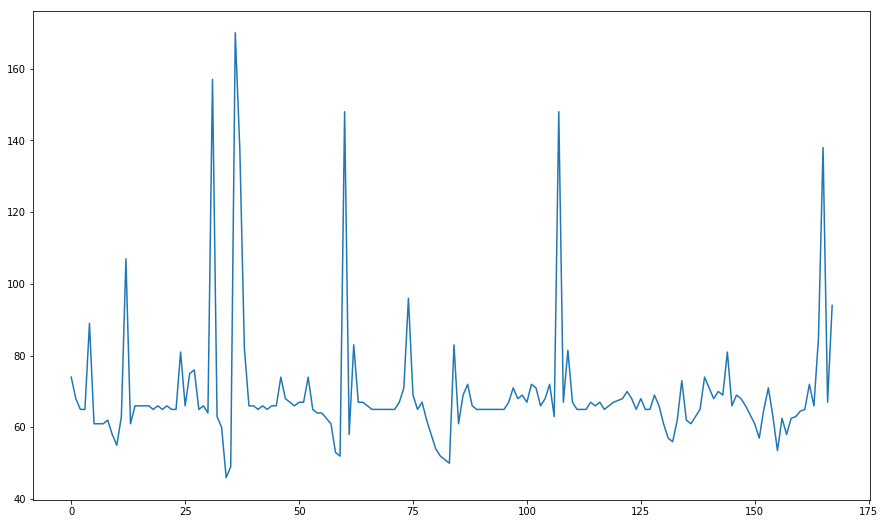

In [19]:
df['hour'] = df['startDate'].map(lambda x: x.hour)
df['weekday'] = df['startDate'].map(lambda x: x.dayofweek)
# df_ = df[df['startDate'] > '2017-05-15 00:00:00']
df_ = df.groupby(['weekday','hour']).median() # Monday is 0
df_.index = np.arange(168)

fig, ax = plt.subplots(figsize=(15,9))
ax.plot(df_.index, df_['value'])